### Import required libraries

In [8]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
import json
import gzip

### Load Data 


In [61]:
# parse the labels

def parse_labels(label_file_path):
    data = []
    with open(label_file_path, 'r') as f:
        f.readline() # first line is header
        for line in f:
            gene_id, transcript_id, position, label = line.strip().split(',')
            data.append({
                'gene_id': gene_id,
                'transcript_id': transcript_id,
                'position': int(position),
                'label': int(label)
            })
    return pd.DataFrame(data)

label_df = parse_labels("../data/data.info.labelled")

# export the labels to a csv file
# label_df.to_csv('../data/labels.csv', index=False)

# print(label_df.head())

In [289]:
# parse the features

def parse_features(feature_file_path):
    rows = []

    with gzip.open(feature_file_path, 'rt', encoding='utf-8') as file:
        for line in file:
            data = json.loads(line)

            for transcript_id, positions in data.items():
                for position, flanking_data in positions.items():
                    for flanking_nucleotide, features_list in flanking_data.items():
                        for features in features_list:
                            row = {
                                "transcript_id": transcript_id,
                                "position": int(position),
                                "flanking_nucleotide": flanking_nucleotide,
                                "dwelling_time_(-1)": features[0],
                                "std_dev_(-1)": features[1],
                                "mean_signal_(-1)": features[2],
                                "dwelling_time_central": features[3],
                                "std_dev_central": features[4],
                                "mean_signal_central": features[5],
                                "dwelling_time_(+1)": features[6],
                                "std_dev_(+1)": features[7],
                                "mean_signal_(+1)": features[8]
                            }
                            rows.append(row)  # Append each parsed entry to rows

    return pd.DataFrame(rows)

# features_df = parse_features("../data/dataset0.json.gz")

# print(features_df.head())

     transcript_id  position flanking_nucleotide  dwelling_time_(-1)  \
0  ENST00000000233       244             AAGACCA             0.00299   
1  ENST00000000233       244             AAGACCA             0.00631   
2  ENST00000000233       244             AAGACCA             0.00465   
3  ENST00000000233       244             AAGACCA             0.00398   
4  ENST00000000233       244             AAGACCA             0.00664   

   std_dev_(-1)  mean_signal_(-1)  dwelling_time_central  std_dev_central  \
0          2.06             125.0                0.01770            10.40   
1          2.53             125.0                0.00844             4.67   
2          3.92             109.0                0.01360            12.00   
3          2.06             125.0                0.00830             5.01   
4          2.92             120.0                0.00266             3.94   

   mean_signal_central  dwelling_time_(+1)  std_dev_(+1)  mean_signal_(+1)  
0                122.0     

In [6]:
features_df = pd.read_csv("../data/features.csv")
label_df = pd.read_csv('../data/labels.csv')

### Train test split


In [290]:
# split by genes
unique_genes = label_df['gene_id'].unique()
train_genes, test_genes = train_test_split(unique_genes, test_size=0.2, random_state=49)

# split transcripts based on genes
train_transcript = label_df[label_df['gene_id'].isin(train_genes)]["transcript_id"]
test_transcript = label_df[label_df['gene_id'].isin(test_genes)]["transcript_id"]
train_df = features_df[features_df['transcript_id'].isin(train_transcript)]
test_df = features_df[features_df['transcript_id'].isin(test_transcript)]

print(train_df.head())
print(test_df.head())
print(len(train_df))
print(len(test_df))

     transcript_id  position flanking_nucleotide  dwelling_time_(-1)  \
0  ENST00000000233       244             AAGACCA             0.00299   
1  ENST00000000233       244             AAGACCA             0.00631   
2  ENST00000000233       244             AAGACCA             0.00465   
3  ENST00000000233       244             AAGACCA             0.00398   
4  ENST00000000233       244             AAGACCA             0.00664   

   std_dev_(-1)  mean_signal_(-1)  dwelling_time_central  std_dev_central  \
0          2.06             125.0                0.01770            10.40   
1          2.53             125.0                0.00844             4.67   
2          3.92             109.0                0.01360            12.00   
3          2.06             125.0                0.00830             5.01   
4          2.92             120.0                0.00266             3.94   

   mean_signal_central  dwelling_time_(+1)  std_dev_(+1)  mean_signal_(+1)  
0                122.0     

### Combine reads

In [26]:
# combine reads using weighted average

'''
def weighted_combine_reads(df):
    def weighted_avg(group, value_col, weight_col):
        d = group[value_col]
        w = 1 / (group[weight_col] ** 2)
        if w.sum() == 0:
            return float('nan')
        return (d * w).sum() / w.sum()

    grouped = df.groupby(['transcript_id', 'position', 'flanking_nucleotide'])
    combined_df = grouped.apply(
        lambda group: pd.Series({
            'dwelling_time_(-1)': weighted_avg(group, 'dwelling_time_(-1)', 'std_dev_(-1)'),
            'mean_signal_(-1)': weighted_avg(group, 'mean_signal_(-1)', 'std_dev_(-1)'),
            'mean_range_(-1)': max(group['mean_signal_(-1)']) - min(group['mean_signal_(-1)']),
            'dwelling_time_central': weighted_avg(group, 'dwelling_time_central', 'std_dev_central'),
            'mean_signal_central': weighted_avg(group, 'mean_signal_central', 'std_dev_central'),
            'mean_range_central': max(group['mean_signal_central']) - min(group['mean_signal_central']),
            'dwelling_time_(+1)': weighted_avg(group, 'dwelling_time_(+1)', 'std_dev_(+1)'),
            'mean_signal_(+1)': weighted_avg(group, 'mean_signal_(+1)', 'std_dev_(+1)'),
            'mean_range_(+1)': max(group['mean_signal_(+1)']) - min(group['mean_signal_(+1)'])
        }), include_groups=False
    ).reset_index()

    # Explicitly include grouping columns to avoid warnings
    combined_df = combined_df[['transcript_id', 'position', 'flanking_nucleotide', 
                               'dwelling_time_(-1)', 'mean_signal_(-1)', 'mean_range_(-1)', 
                               'dwelling_time_central', 'mean_signal_central', 'mean_range_central', 
                               'dwelling_time_(+1)', 'mean_signal_(+1)', 'mean_range_(+1)']]

    return combined_df

train_combined_weighted = weighted_combine_reads(train_df)
test_combined_weighted = weighted_combine_reads(test_df)
'''

In [16]:
# combine reads using average
train_combined = train_df.groupby(['transcript_id', 'position', 'flanking_nucleotide']).mean().reset_index()
test_combined = test_df.groupby(['transcript_id', 'position', 'flanking_nucleotide']).mean().reset_index()

# Display the resulting DataFrame
print(train_combined.head())
print(test_combined.head())

     transcript_id  position flanking_nucleotide  dwelling_time_(-1)  \
0  ENST00000000233       244             AAGACCA            0.008264   
1  ENST00000000233       261             CAAACTG            0.006609   
2  ENST00000000233       316             GAAACAG            0.007570   
3  ENST00000000233       332             AGAACAT            0.010620   
4  ENST00000000233       368             AGGACAA            0.010701   

   std_dev_(-1)  mean_signal_(-1)  dwelling_time_central  std_dev_central  \
0      4.223784        123.702703               0.009373         7.382162   
1      3.216424        109.681395               0.006813         3.226535   
2      2.940541        105.475676               0.007416         3.642703   
3      6.476350        129.355000               0.008632         2.899200   
4      6.415051        117.924242               0.011479         5.870303   

   mean_signal_central  dwelling_time_(+1)  std_dev_(+1)  mean_signal_(+1)  
0           125.913514     

In [17]:
# merge data with labels
train_labelled = pd.merge(train_combined, label_df[['transcript_id', 'position', 'label']], 
                     on=['transcript_id', 'position'], 
                     how='left')

test_labelled = pd.merge(test_combined, label_df[['transcript_id', 'position', 'label']],
                    on=['transcript_id', 'position'],
                    how='left')

print(train_labelled.head())
print(test_labelled.head())

     transcript_id  position flanking_nucleotide  dwelling_time_(-1)  \
0  ENST00000000233       244             AAGACCA            0.008264   
1  ENST00000000233       261             CAAACTG            0.006609   
2  ENST00000000233       316             GAAACAG            0.007570   
3  ENST00000000233       332             AGAACAT            0.010620   
4  ENST00000000233       368             AGGACAA            0.010701   

   std_dev_(-1)  mean_signal_(-1)  dwelling_time_central  std_dev_central  \
0      4.223784        123.702703               0.009373         7.382162   
1      3.216424        109.681395               0.006813         3.226535   
2      2.940541        105.475676               0.007416         3.642703   
3      6.476350        129.355000               0.008632         2.899200   
4      6.415051        117.924242               0.011479         5.870303   

   mean_signal_central  dwelling_time_(+1)  std_dev_(+1)  mean_signal_(+1)  \
0           125.913514    

### Oversampling

I use random oversampling here instead of SMOTE because it could generate synthetic transcript IDs and positions, which are not valid.


In [20]:
X = train_labelled.drop('label', axis=1)  # Features
y = train_labelled['label']               # Target (label)

# Define the oversampler
ros = RandomOverSampler(sampling_strategy='auto', random_state=42)

# Apply oversampling
X_resampled, y_resampled = ros.fit_resample(X, y)

# Combine the resampled features and labels into a new DataFrame
resampled_train_df = pd.concat([pd.DataFrame(X_resampled, columns=X.columns), pd.Series(y_resampled, name='label')], axis=1)

# Display the new shape of the resampled dataset
print(len(resampled_train_df))

185164


### Feature Engineering

#### Normalization

In [25]:
# Initialize the StandardScaler
scaler = StandardScaler()

'''
# weighted avg combined reads
numeric_columns = ['dwelling_time_(-1)', 'mean_signal_(-1)', 'mean_range_(-1)',
                   'dwelling_time_central', 'mean_signal_central', 'mean_range_central',
                   'dwelling_time_(+1)', 'mean_signal_(+1)', 'mean_range_(+1)']
'''

# avg combined reads
numeric_columns = ['dwelling_time_(-1)', 'std_dev_(-1)', 'mean_signal_(-1)',
                   'dwelling_time_central', 'std_dev_central', 'mean_signal_central',
                   'dwelling_time_(+1)', 'std_dev_(+1)', 'mean_signal_(+1)']

# scale the numeric columns of train and test data
# standardized_train_df = resampled_train_df.copy()
standardized_train_df = train_labelled.copy()
standardized_train_df[numeric_columns] = scaler.fit_transform(train_labelled[numeric_columns])

standardized_test_df = test_labelled.copy()
standardized_test_df[numeric_columns] = scaler.fit_transform(test_labelled[numeric_columns])

# View the standardized dataset
print(standardized_train_df.head())
print(standardized_test_df.head())

     transcript_id  position flanking_nucleotide  dwelling_time_(-1)  \
0  ENST00000000233       244             AAGACCA            0.088436   
1  ENST00000000233       261             CAAACTG           -0.838156   
2  ENST00000000233       316             GAAACAG           -0.300297   
3  ENST00000000233       332             AGAACAT            1.407322   
4  ENST00000000233       368             AGGACAA            1.452251   

   std_dev_(-1)  mean_signal_(-1)  dwelling_time_central  std_dev_central  \
0     -0.061855          1.138815               0.739554         1.020961   
1     -0.582332         -0.101667              -0.778025        -0.883882   
2     -0.724875         -0.473752              -0.420844        -0.693121   
3      1.101990          1.638881               0.300377        -1.033925   
4      1.070318          0.627588               1.987836         0.327959   

   mean_signal_central  dwelling_time_(+1)  std_dev_(+1)  mean_signal_(+1)  \
0             1.199076    

## Model Training

In [180]:
# clear all variables in the workspace
# %reset -f

In [30]:
# inputs
import pandas as pd

train = pd.read_csv('../data/train.csv')
# train = pd.read_csv('../data/train_oversampled.csv')
test = pd.read_csv('../data/test.csv')

# drop rows with NaN values
test = test.dropna()

In [51]:
# encode the nucleotides

pd.set_option("future.no_silent_downcasting", True) # to avoid warning

def encode_nucleotide(df):
    df = df.copy()

    # split into 7 columns
    nucleotides = df['flanking_nucleotide'].apply(lambda x: pd.Series(list(x)))
    nucleotides.columns = ['nucleotide_' + str(i) for i in range(7)]

    # encode the nucleotides
    nucleotides = nucleotides.replace({'A': 1, 'C': 2, 'G': 3, 'T': 4})

    # scale the encoded nucleotides
    scaler = StandardScaler()
    nucleotides_scaled = scaler.fit_transform(nucleotides)

    # concatenate the encoded nucleotides with the original dataframe
    df = pd.concat([df.reset_index(drop=True), pd.DataFrame(nucleotides_scaled, columns=nucleotides.columns)], axis=1)

    # # one-hot encode the nucleotides
    # nucleotides = pd.get_dummies(df['flanking_nucleotide'])

    # # scale the encoded nucleotides
    # scaler = StandardScaler()
    # nucleotides_scaled = scaler.fit_transform(nucleotides)

    # # concatenate the encoded nucleotides with the original dataframe
    # df = pd.concat([df.reset_index(drop=True), pd.DataFrame(nucleotides_scaled, columns=nucleotides.columns)], axis=1)

    # drop the original nucleotide column
    df = df.drop('flanking_nucleotide', axis=1)
    
    return df

### NN

In [58]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

torch.manual_seed(42)

# encode the nucleotides
train_encoded = encode_nucleotide(train)
test_encoded = encode_nucleotide(test)

# Separate features and labels
X_train = train_encoded.drop(columns=['transcript_id', 'position', 'label'])
y_train = train_encoded['label']

X_test = test_encoded.drop(columns=['transcript_id', 'position', 'label'])
y_test = test_encoded['label']

# Convert to PyTorch tensors
X_train = torch.tensor(X_train.values, dtype=torch.float32)
y_train = torch.tensor(y_train.values, dtype=torch.float32)
X_test = torch.tensor(X_test.values, dtype=torch.float32)
y_test = torch.tensor(y_test.values, dtype=torch.float32)

In [59]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(X_train.shape[1], 16)
        self.layer2 = nn.Linear(16, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.layer1(x))
        x = self.sigmoid(self.layer2(x))
        return x
    
# Initialize the model, loss function, and optimizer
model = NeuralNetwork()
loss_fn = nn.BCELoss() # Binary Cross-Entropy Loss
optimizer = optim.Adam(model.parameters(), lr=0.1)

# Train the model
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    outputs = model(X_train).squeeze()
    loss = loss_fn(outputs, y_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

# save the model
torch.save(model.state_dict(), '../data/model.pth')

Epoch [10/100], Loss: 0.2136
Epoch [20/100], Loss: 0.1639
Epoch [30/100], Loss: 0.1505
Epoch [40/100], Loss: 0.1417
Epoch [50/100], Loss: 0.1380
Epoch [60/100], Loss: 0.1336
Epoch [70/100], Loss: 0.1293
Epoch [80/100], Loss: 0.1270
Epoch [90/100], Loss: 0.1257
Epoch [100/100], Loss: 0.1247


C:\Users\Yong Zhi Yi\AppData\Local\Temp\ipykernel_26248\963023689.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('../data/model.pth'))


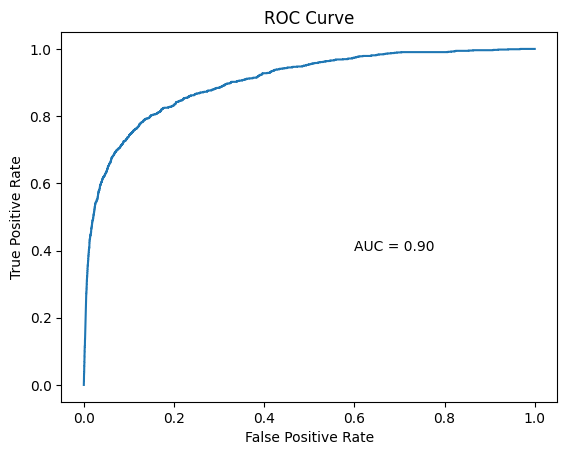

Accuracy: 0.96


In [60]:
# load a pretrained model
model = NeuralNetwork()
model.load_state_dict(torch.load('../data/model.pth'))

# Evaluate the model
model.eval()
with torch.no_grad():
    y_pred_proba = model(X_test).squeeze()
    auc = roc_auc_score(y_test, y_pred_proba)
    # plot roc-auc
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    plt.plot(fpr, tpr)
    plt.annotate(f'AUC = {auc:.2f}', (0.6, 0.4))
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.show()

# set threshold at 0.5, calculate accuracy
y_pred = y_pred_proba >= 0.5
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

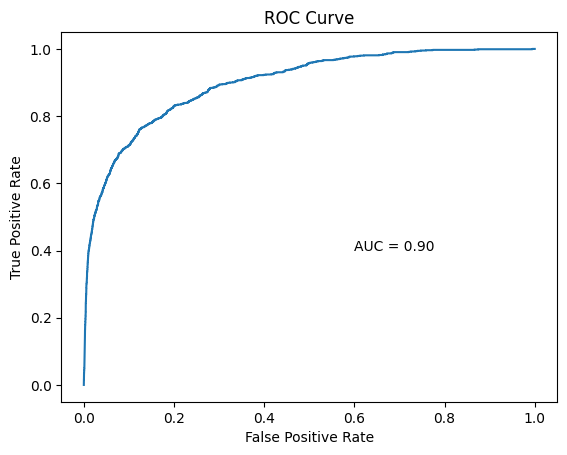

Accuracy: 0.96


In [11]:
# Evaluate the model
model.eval()
with torch.no_grad():
    y_pred_proba = model(X_test).squeeze()
    auc = roc_auc_score(y_test, y_pred_proba)
    # plot roc-auc
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    plt.plot(fpr, tpr)
    plt.annotate(f'AUC = {auc:.2f}', (0.6, 0.4))
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.show()

# set threshold at 0.5, calculate accuracy
y_pred = y_pred_proba >= 0.5
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')